<a href="https://colab.research.google.com/github/mahdimalverdi/DM-Project2/blob/main/DM_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
!pip install vaderSentiment

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
analyser = sia()

In [4]:
!wget https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/interactions.xlsx

--2021-07-03 18:20:31--  https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/interactions.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13011069 (12M) [application/octet-stream]
Saving to: ‘interactions.xlsx.1’

interactions.xlsx.1 100%[===================>]  12.41M  --.-KB/s    in 0.1s    

2021-07-03 18:20:32 (103 MB/s) - ‘interactions.xlsx.1’ saved [13011069/13011069]



In [5]:
!wget https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/dataset.xls

--2021-07-03 18:20:33--  https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/dataset.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1161216 (1.1M) [application/octet-stream]
Saving to: ‘dataset.xls.1’

dataset.xls.1       100%[===================>]   1.11M  --.-KB/s    in 0.06s   

2021-07-03 18:20:33 (17.2 MB/s) - ‘dataset.xls.1’ saved [1161216/1161216]



In [6]:
interactions = pd.read_excel('interactions.xlsx')

In [7]:
def analyse(row):
    return analyser.polarity_scores(row['Extracted Interaction Text'])['compound']

interactions['compound'] = interactions.apply(analyse, axis=1)

In [8]:
dataset = pd.read_excel('dataset.xls')

In [9]:
compound_by_from_email_id = interactions.groupby(by=['fromEmailId'], dropna=False)['compound'].mean().to_dict()

def get_compound(row):
    return compound_by_from_email_id[row['SalesAgentEmailID']]

dataset['interaction_compound'] = dataset.apply(get_compound, axis=1)

In [18]:
def set_stage_rate(key, column):
  won_count = dataset.groupby(by=[key], dropna=False).apply(lambda x : x[x['Stage'] == 'Won'].count())['Stage'].to_dict()
  count = dataset.groupby(by=[key], dropna=False).count()['Stage'].to_dict()

  def get_rate(row):
    return won_count[row[key]] / count[row[key]] 

  dataset[column] = dataset.apply(get_rate, axis=1)

In [11]:
def set_date_diff_rate(key, column):
  won_count = dataset.groupby(by=[key], dropna=False).apply(lambda x : x[x['Stage'] == 'Won']['diff_date'].mean()).to_dict()
  count = dataset.groupby(by=[key], dropna=False).count().to_dict()

  def get_rate(row):
    return won_count[row[key]]

  dataset[column] = dataset.apply(get_rate, axis=1)

In [12]:
dataset['diff_date'] = dataset.apply(lambda x: (x['Close Date'] - x['Created Date']).days , axis=1)
dataset['close_number'] = dataset.apply(lambda x: x['Close Date'].timestamp() , axis=1)
dataset['created_number'] = dataset.apply(lambda x: x['Created Date'].timestamp() , axis=1)


In [19]:
set_stage_rate('ContactEmailID', 'prod_acc_rate')
set_stage_rate('SalesAgentEmailID', 'win_rate')
set_date_diff_rate('Product', 'avg_sale_cyc')

In [20]:
sales_agent_email_id = 0

dataset_by_sales_agent_email_id = dataset.groupby(by=['SalesAgentEmailID'], dropna=False).apply(lambda x: x.index[0]).to_dict()
for item in dataset_by_sales_agent_email_id:
  dataset_by_sales_agent_email_id[item] = sales_agent_email_id 
  sales_agent_email_id += 1


dataset['sales_agent_email_id_number'] = dataset.apply(lambda x: dataset_by_sales_agent_email_id[x['SalesAgentEmailID']], axis=1)

In [21]:
import math

dataset_by_product = dataset.groupby(by=['Product'], dropna=False).apply(lambda x: x['Close_Value'].median()).to_dict()
dataset_by_product

dataset['Close_Value'] = dataset.apply(lambda x: dataset_by_product.get(x['Product']) if math.isnan(x['Close_Value']) else x['Close_Value'], axis=1)
dataset

,Unnamed: 0,Customer,Agent,SalesAgentEmailID,ContactEmailID,Stage,Product,Close_Value,Created Date,Close Date,interaction_compound,diff_date,close_number,created_number,prod_acc_rate,win_rate,avg_sale_cyc,sales_agent_email_id_number
0,0,Konex,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255.0,2016-01-04,2016-05-24,0.353368,141,1.464048e+09,1.451866e+09,0.525000,0.461538,312.122034,4
1,1,Finjob,Rosalina Dieter,rosalina@piedpiper.com,belinda@finjob.com,Won,MG Special,45.0,2016-01-04,2016-11-02,0.352900,303,1.478045e+09,1.451866e+09,0.490196,0.436242,312.192647,23
2,2,Kinnamplus,Donn Cantrell,donn@piedpiper.com,monte@kinnamplus.com,Lost,MG Special,61.0,2016-01-06,2016-12-07,0.352965,336,1.481069e+09,1.452038e+09,0.435294,0.589744,312.192647,7
3,3,Genco Pura Olive Oil Company,James Ascencio,james@piedpiper.com,karole@gencopuraoliveoilcompany.com,In Progress,MG Advanced,1054.0,2016-01-06,2016-09-11,0.357483,249,1.473552e+09,1.452038e+09,0.480392,0.515021,334.398964,12
4,4,Stanredtax,Lajuana Vencill,lajuana@piedpiper.com,candice@stanredtax.com,Won,MG Advanced,3180.0,2016-01-07,2016-01-31,0.342820,24,1.454198e+09,1.452125e+09,0.577982,0.407273,334.398964,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7795,7795,Vehement Capital Partners,Jonathan Berthelot,jonathan@piedpiper.com,lavonia@vehementcapitalpartners.com,In Progress,GTX Basic,590.0,2018-12-30,2019-07-22,0.348047,204,1.563754e+09,1.546128e+09,0.416667,0.492013,302.947302,13
7796,7796,Hottechi,Marty Freudenburg,marty@piedpiper.com,juliette@hottechi.com,In Progress,MG Advanced,3284.0,2018-12-30,2019-05-26,0.355402,147,1.558829e+09,1.546128e+09,0.526596,0.426295,334.398964,18
7797,7797,Umbrella Corporation,Anna Snelling,anna@piedpiper.com,orpha@umbrellacorporation.com,In Progress,GTX Plus Pro,300.0,2018-12-31,2019-04-15,0.352027,105,1.555286e+09,1.546214e+09,0.465116,0.465995,313.434272,0
7798,7798,Rundofase,Gladys Colclough,gladys@piedpiper.com,crista@rundofase.com,In Progress,MG Special,3284.0,2018-12-31,2019-05-16,0.357871,136,1.557965e+09,1.546214e+09,0.531532,0.423611,312.192647,10


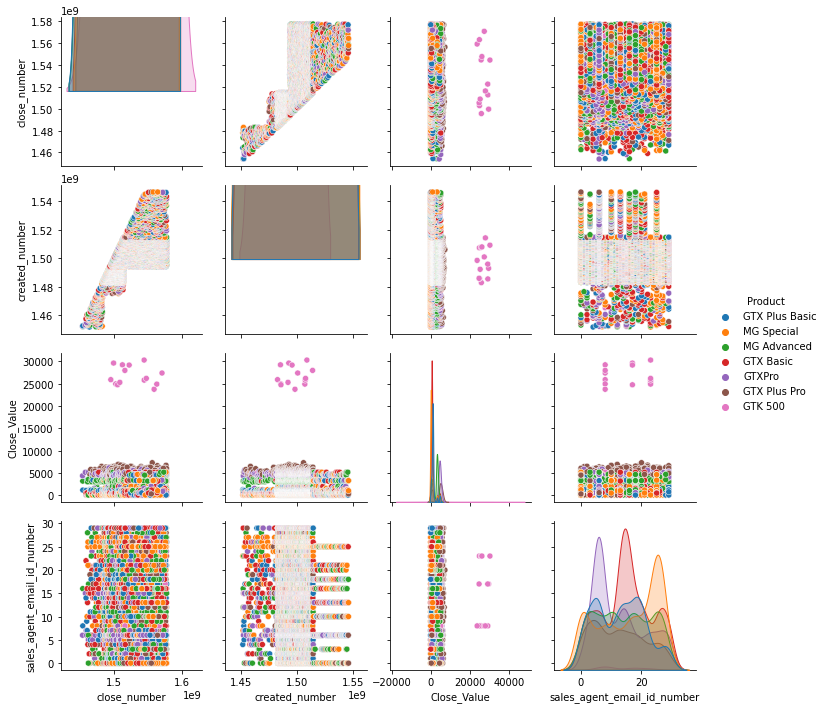

In [22]:
sb.pairplot(dataset, hue="Product", vars=['close_number', 'created_number', 'Close_Value', 'sales_agent_email_id_number'])

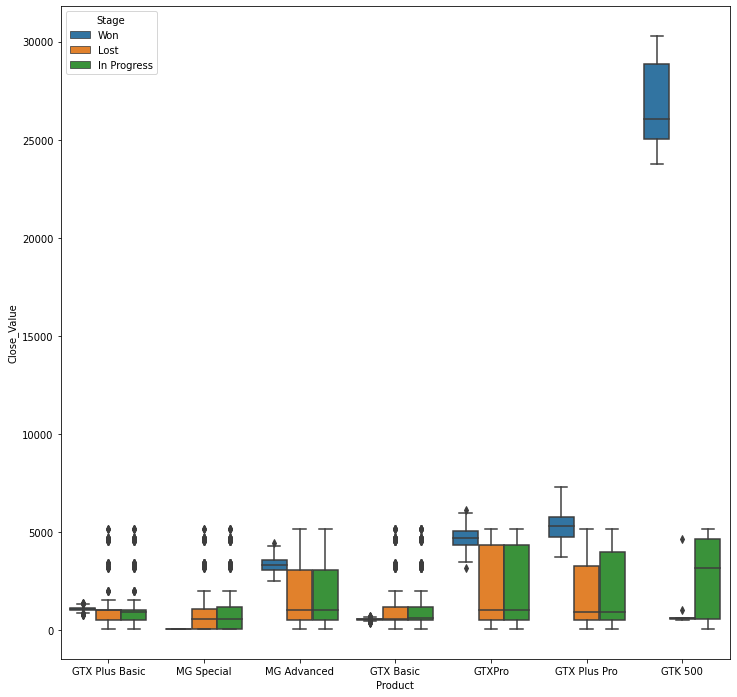

In [23]:
f, ax = plt.subplots(figsize=(12, 12))
sb.boxplot(x='Product',y='Close_Value',hue='Stage',data=dataset,ax=ax)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 95.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 89.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 94.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 93.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 95.3% of the points cannot be placed; y

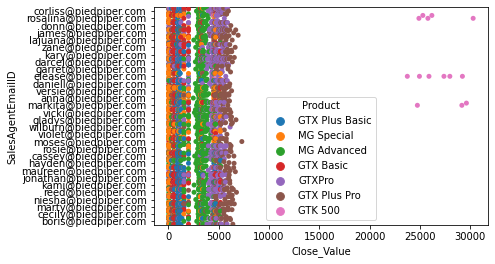

In [41]:
sb.swarmplot(data=dataset, x="Close_Value", y="SalesAgentEmailID", hue="Product")

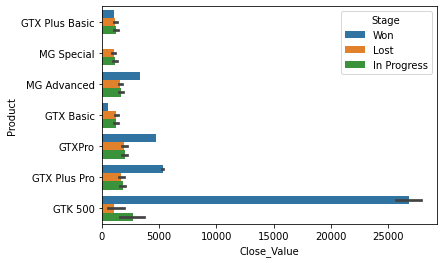

In [42]:
sb.barplot(y='Product',x='Close_Value',hue='Stage',data=dataset)

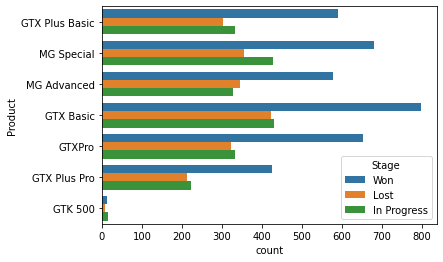

In [26]:
sb.countplot(y='Product',hue='Stage',data=dataset)

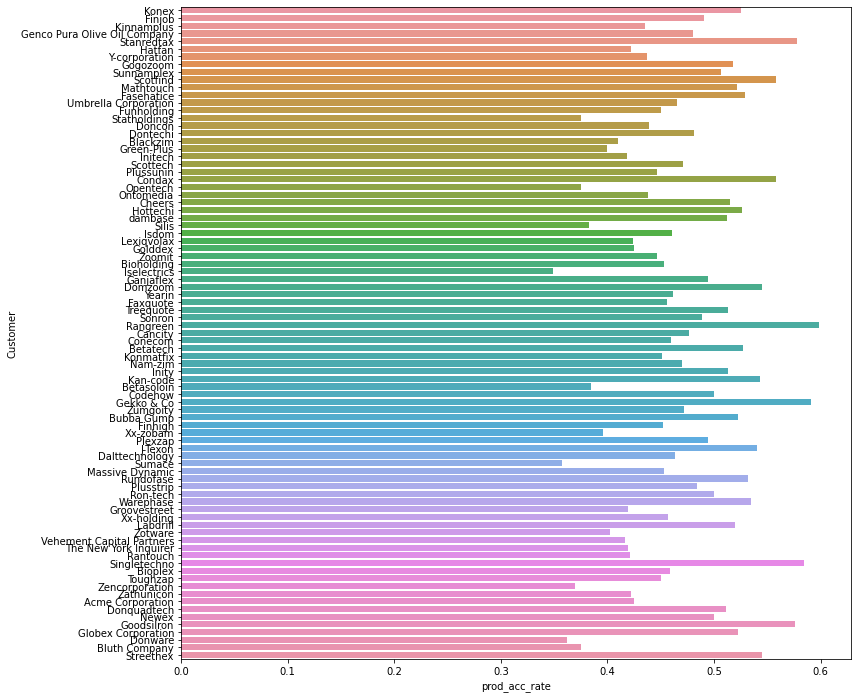

In [27]:
f, ax = plt.subplots(figsize=(12, 12))
sb.barplot(y='Customer',x='prod_acc_rate',data=dataset,ax=ax)

In [28]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
OH_enc = OneHotEncoder(handle_unknown='ignore',sparse= False)

def OHE(df,col):
    encprod=pd.DataFrame(OH_enc.fit_transform(df[col]))
    encprod.index = df.index
    encprod.columns=OH_enc.get_feature_names(col)
    df=pd.concat([df,encprod],axis=1)
    df=df.drop(col,axis=1)
    return df

In [29]:
dataset['gold_cyc'] = dataset.apply(lambda x: 1 if x['diff_date'] < x['avg_sale_cyc'] else 0, axis=1)

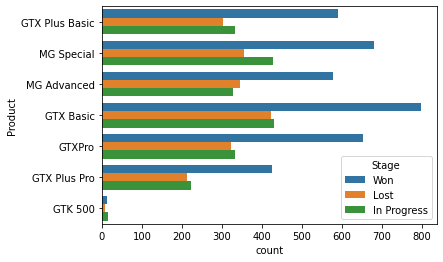

In [30]:
sb.countplot(y='Product',hue='Stage',data=dataset)

In [31]:
dataset

,Unnamed: 0,Customer,Agent,SalesAgentEmailID,ContactEmailID,Stage,Product,Close_Value,Created Date,Close Date,interaction_compound,diff_date,close_number,created_number,prod_acc_rate,win_rate,avg_sale_cyc,sales_agent_email_id_number,gold_cyc
0,0,Konex,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255.0,2016-01-04,2016-05-24,0.353368,141,1.464048e+09,1.451866e+09,0.525000,0.461538,312.122034,4,1
1,1,Finjob,Rosalina Dieter,rosalina@piedpiper.com,belinda@finjob.com,Won,MG Special,45.0,2016-01-04,2016-11-02,0.352900,303,1.478045e+09,1.451866e+09,0.490196,0.436242,312.192647,23,1
2,2,Kinnamplus,Donn Cantrell,donn@piedpiper.com,monte@kinnamplus.com,Lost,MG Special,61.0,2016-01-06,2016-12-07,0.352965,336,1.481069e+09,1.452038e+09,0.435294,0.589744,312.192647,7,0
3,3,Genco Pura Olive Oil Company,James Ascencio,james@piedpiper.com,karole@gencopuraoliveoilcompany.com,In Progress,MG Advanced,1054.0,2016-01-06,2016-09-11,0.357483,249,1.473552e+09,1.452038e+09,0.480392,0.515021,334.398964,12,1
4,4,Stanredtax,Lajuana Vencill,lajuana@piedpiper.com,candice@stanredtax.com,Won,MG Advanced,3180.0,2016-01-07,2016-01-31,0.342820,24,1.454198e+09,1.452125e+09,0.577982,0.407273,334.398964,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7795,7795,Vehement Capital Partners,Jonathan Berthelot,jonathan@piedpiper.com,lavonia@vehementcapitalpartners.com,In Progress,GTX Basic,590.0,2018-12-30,2019-07-22,0.348047,204,1.563754e+09,1.546128e+09,0.416667,0.492013,302.947302,13,1
7796,7796,Hottechi,Marty Freudenburg,marty@piedpiper.com,juliette@hottechi.com,In Progress,MG Advanced,3284.0,2018-12-30,2019-05-26,0.355402,147,1.558829e+09,1.546128e+09,0.526596,0.426295,334.398964,18,1
7797,7797,Umbrella Corporation,Anna Snelling,anna@piedpiper.com,orpha@umbrellacorporation.com,In Progress,GTX Plus Pro,300.0,2018-12-31,2019-04-15,0.352027,105,1.555286e+09,1.546214e+09,0.465116,0.465995,313.434272,0,1
7798,7798,Rundofase,Gladys Colclough,gladys@piedpiper.com,crista@rundofase.com,In Progress,MG Special,3284.0,2018-12-31,2019-05-16,0.357871,136,1.557965e+09,1.546214e+09,0.531532,0.423611,312.192647,10,1


In [32]:
def remove_useless_columns(df):
  df.reset_index(drop=True,inplace=True)
  df=df.drop(['Unnamed: 0' ,'Customer', 'Agent', 'SalesAgentEmailID', 'ContactEmailID','Created Date', 'Close Date','avg_sale_cyc', 'diff_date', 'close_number', 'created_number'],axis=1)
  return df

in_progress_df = remove_useless_columns(dataset.loc[dataset['Stage']=='In Progress',dataset.columns])
sold_df = remove_useless_columns(dataset.loc[dataset['Stage']!='In Progress',dataset.columns])

lb=LabelBinarizer()
lb.fit_transform(sold_df['Stage'])
deal_class=sold_df['Stage']
sold_df=sold_df.drop(['Stage'],axis=1)

s = (sold_df.dtypes == 'object')
object_cols = list(s[s].index)

sold_df=OHE(sold_df,object_cols)
in_progress_df=OHE(in_progress_df,object_cols)

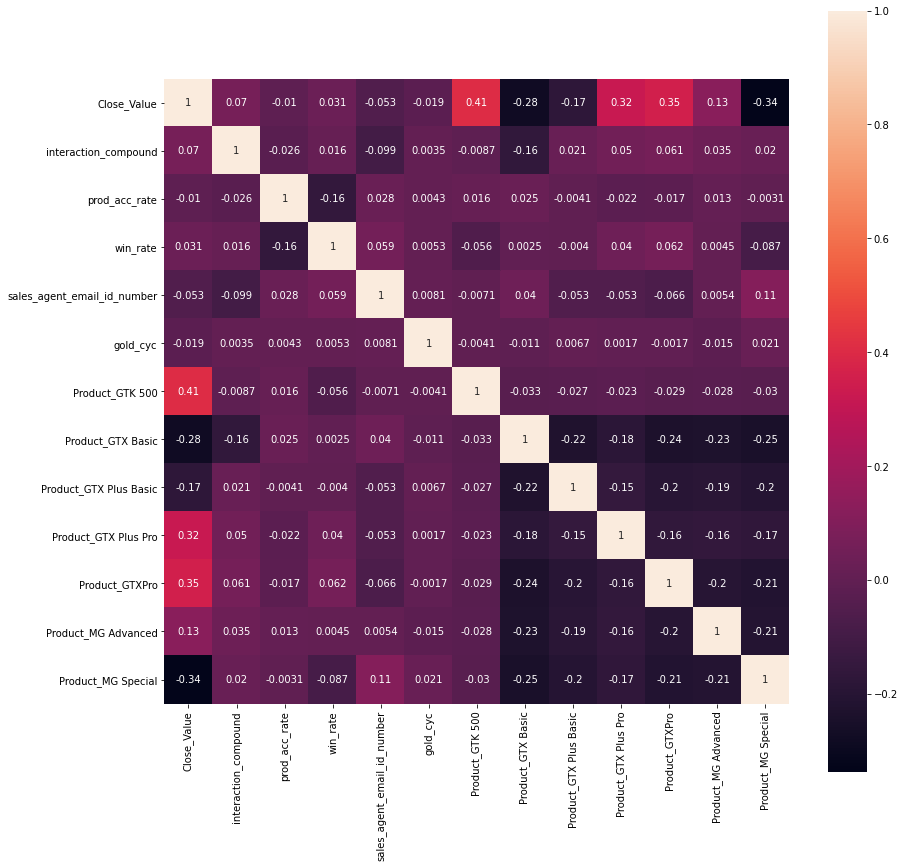

In [33]:
correlation=sold_df.corr()
plt.figure(figsize=(14,14))
sb.heatmap(data=correlation,square=True,annot=True)

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

train_X, val_X, train_y, val_y = train_test_split(sold_df, deal_class, random_state = 0)

lr = LogisticRegression() 
lr.fit(train_X, train_y) 
pred = lr.predict(val_X) 
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

        Lost       1.00      0.29      0.46       482
         Won       0.74      1.00      0.85       946

    accuracy                           0.76      1428
   macro avg       0.87      0.65      0.65      1428
weighted avg       0.82      0.76      0.72      1428



In [70]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(train_X, train_y) 
pred = neigh.predict(val_X) 
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

        Lost       0.76      0.78      0.77       482
         Won       0.89      0.88      0.88       946

    accuracy                           0.84      1428
   macro avg       0.82      0.83      0.83      1428
weighted avg       0.84      0.84      0.84      1428



In [71]:
y_pred_proba = neigh.predict_proba(val_X)[:,1]

In [72]:
y_pred_proba

array([0.42857143, 1.        , 1.        , ..., 0.71428571, 1.        ,
       1.        ])

In [74]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_y, y_pred_proba, pos_label='Won')

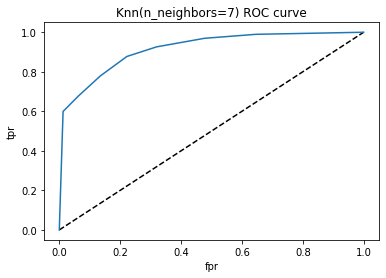

In [75]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=7) ROC curve')
plt.show()

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(val_y,pred)
pd.crosstab(val_y, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Lost,Won,All
True,,,
Lost,375,107,482
Won,116,830,946
All,491,937,1428


In [36]:
from sklearn.svm import SVC
svc = SVC(gamma=2, C=1)
svc.fit(train_X, train_y) 
pred = svc.predict(val_X) 
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

        Lost       0.72      0.16      0.26       482
         Won       0.69      0.97      0.81       946

    accuracy                           0.69      1428
   macro avg       0.70      0.56      0.53      1428
weighted avg       0.70      0.69      0.62      1428



In [51]:
from sklearn.ensemble import RandomForestClassifier
neigh =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
neigh.fit(train_X, train_y) 
pred = neigh.predict(val_X) 
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

        Lost       1.00      0.01      0.03       482
         Won       0.67      1.00      0.80       946

    accuracy                           0.67      1428
   macro avg       0.83      0.51      0.41      1428
weighted avg       0.78      0.67      0.54      1428



In [45]:
from sklearn.tree import DecisionTreeClassifier
neigh = DecisionTreeClassifier(max_depth=5)
neigh.fit(train_X, train_y) 
pred = neigh.predict(val_X) 
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

        Lost       0.98      0.26      0.41       482
         Won       0.73      1.00      0.84       946

    accuracy                           0.75      1428
   macro avg       0.85      0.63      0.62      1428
weighted avg       0.81      0.75      0.69      1428



In [46]:
from sklearn.naive_bayes import GaussianNB
neigh = GaussianNB()
neigh.fit(train_X, train_y) 
pred = neigh.predict(val_X) 
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

        Lost       0.40      0.30      0.35       482
         Won       0.68      0.77      0.73       946

    accuracy                           0.61      1428
   macro avg       0.54      0.54      0.54      1428
weighted avg       0.59      0.61      0.60      1428



In [47]:
from sklearn.neural_network import MLPClassifier
neigh = MLPClassifier(alpha=1, max_iter=1000)
neigh.fit(train_X, train_y) 
pred = neigh.predict(val_X) 
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

        Lost       0.76      0.39      0.52       482
         Won       0.75      0.94      0.83       946

    accuracy                           0.75      1428
   macro avg       0.75      0.66      0.67      1428
weighted avg       0.75      0.75      0.73      1428



In [78]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, train_X, train_y, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [79]:
sold_df

,Close_Value,interaction_compound,prod_acc_rate,win_rate,sales_agent_email_id_number,gold_cyc,Product_GTK 500,Product_GTX Basic,Product_GTX Plus Basic,Product_GTX Plus Pro,Product_GTXPro,Product_MG Advanced,Product_MG Special
0,1255.0,0.353368,0.525000,0.461538,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,45.0,0.352900,0.490196,0.436242,23,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,61.0,0.352965,0.435294,0.589744,7,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3180.0,0.342820,0.577982,0.407273,16,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,517.0,0.351423,0.422222,0.476038,29,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,5085.0,0.352245,0.512821,0.463964,6,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5707,555.0,0.355410,0.493976,0.673267,22,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5708,5169.0,0.352245,0.513043,0.463964,6,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5709,4880.0,0.352245,0.513043,0.463964,6,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
